# Влияние условий жизни учащихся на академическую успеваемость по математике: эксплораторный анализ данных 

## Цель проекта

Целью данного проекта является исследование взаимосвязи между условиями жизни, уровнем благополучия учащихся в возрасте от 15 до 22 лет и их академическими успехами по математике. Анализ проводится с целью заблаговременного выявления учашихся, находящихся в потенциальной группе риска.

## Задача проекта

Глобальной задачей данного исследования является использование методов машинного обучения для построения модели, которая бы предсказывала результаты государственного экзамена по математике. Однако основной задачей данного проекта стоит именно проведение эксплораторного анализа данных с целью выявить наиболее релевантные переменные, которые будут включены в будущую модель.

### Начало работы с данными

Импортируем все необходимые библиотеки и загружаем данные:

In [159]:
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [160]:
ma = pd.read_csv('stud_math.xls')

### **Общие характеристики датасета**

* Анализируемый датасет содержит **29** потенциальных предикторов для предсказания финального количества баллов, набранного учеником по математике (`score`). 
* Всего датасет содержит **395** наблюдений, однако среди некоторых переменных присутствует небольшое количество пропущенных значений.

### **Анализ зависимой переменной (`score`)**

**Описательные статистики:**

In [161]:
ma_desc = pd.DataFrame({'Value': ma['score'].describe()})
ma_desc = ma_desc.reset_index().rename(columns={'index': 'Statistic'})
round(ma_desc, 1)

,Statistic,Value
0,count,389.0
1,mean,52.3
2,std,22.9
3,min,0.0
4,25%,40.0
5,50%,55.0
6,75%,70.0
7,max,100.0


* Итак, первичные описательные статистики говорят о том, что диапазон оценок по математике варируется **от 0 до 100 баллов**, со средним значением **52 балла**, медианным - **55 баллов** и стандартным отклонением в **23 балла**. 
* Большинство типичных значений попадает в диапазон от 40 до 70 баллов, что соответствует значению межквартильного размаха равному 30 баллам.

**Анализ выбросов:**

Для анализа выбросов количественных переменных я использую функцию, которая берет в аргумент переменную, затем считает:
* 25-й квантиль
* 75-й квантиль
* Межквартильный размах

И на основе этой информации выводит значения **верхней** и **нижней** границы выбросов.

Так работает эта функция на примере переменной `score`:

In [162]:
def check_outliers(var):
    quant25 = var.quantile(0.25)
    quant75 = var.quantile(0.75)
    IQR = quant75 - quant25
    outlier_below = quant25 - 1.5*IQR
    outlier_above = quant75 + 1.5*IQR
    outlier_range = pd.DataFrame(
        [{'lower_bound': outlier_below, 'upper_bound': outlier_above}])
    return outlier_range


check_outliers(ma['score'])

,lower_bound,upper_bound
0,-5.0,115.0


Поскольку все значения переменной `score` находятся в диапазоне от 0 до 100 (как было показано ранее), можем сказать, что выбросов не обнаружено. 

Однако стоит отметить, что нулевой балл по математике - это, скорее всего, техническая запись в данных, означающая, что ученика по каким-либо причинам не было на экзамене (всего таких записей обнаружено 37), поскольку с практической точки зрения вероятность получить оценку "0 баллов" очень мала. 

В ходе дальнейшего анализа наблюдения со значением 0 в переменной `score` рассматриваться не будут.

In [163]:
len(ma.score[ma.score == 0])

37

In [164]:
ma = ma[ma.score != 0]

**Распределение зависимой переменной `score`:**

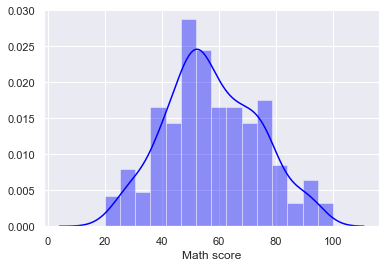

In [165]:
sns.set()
pl = sns.distplot(ma['score'], kde_kws={'clip': (
    0, 100)}, bins=15, color='blue', axlabel='Math score')

По графику распределения баллов по математике видно, что большинство значений находятся в диапазоне от 40 до 70 баллов, что и было показано в разделе "Описальные статистики". Также стоит отметить, что распределение близко к нормальному.

### **Анализ пропущенных значений в датасете:**

In [166]:
miss = pd.DataFrame({'Missings': ma.isna().sum()})
miss = miss.reset_index().rename(columns={'index': 'Variable'})
display(miss)

,Variable,Missings
0,school,0
1,sex,0
2,age,0
3,address,16
4,famsize,24
5,Pstatus,41
6,Medu,2
7,Fedu,21
8,Mjob,17
9,Fjob,32


Как можно заметить, наибольшее количество пропущенных значений имеет переменная "Статус совместного проживания родителей" (41), в то время как некоторые переменные имеют лишь незначительное количество пропусков.

Что касается зависимой переменной (`score`), она имеет **6** пропущенных значений, которые имеет смысл удалить из датасета для дальнейшего анализа. 

В итоге остается датасет с **352** наблюдениями.

In [167]:
ma = ma.dropna(axis=0, subset=['score'])
len(ma)

352

## Анализ количественных переменных

В изучаемом датасете относительно небольшой объем количественных переменных:

* Возраст
* Семейные отношения [1-5: плохие-хорошие] - подобные переменные с 5 значениями и более будем считать количественными
* Количество свободного времени после школы [1-5: мало-много]
* Как часто происходят встречи с друзьми [1-5: редко-часто]
* Оценка здоровья [1-5: плохое-хорошее]
* Количество пропусков

Однако их также можно рассматривать как номинативные (даже возраст в данном случае, но за исключением "пропусков"), поэтому построим несколько типов графиков.

Создадим отдельный датасет только с почти количественными переменными:

In [168]:
ma_quant = ma[['age','famrel','freetime','goout','health','absences', 'score']]
ma_quant

correlation = ma_quant.corr()

Посмотрим на **корреляционный анализ** количественных переменных:

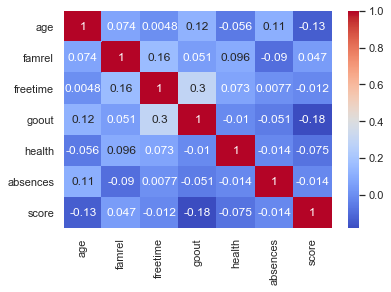

In [169]:
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

Как видно из графика, существует относительно больная корреляция (0.3) между количеством свободного времени и частотой встреч с друзьми. Таким образом, одну из этих переменных имеет смысл намеренно не брать в модель во избежании проблемы мультиколлинеарности предикторов. Пусть это будет переменная `goout` (частота встреч с друзьями).

Также, заметных корреляций между переменной `score` и предикторами не обнаружено.

А сейчас более подробно проанализируем количественные переменные по отдельности:

### **Возраст ученика**

**Анализ пропущенных значений:**

Для анализа пропущенных значений в каждой переменной я использую функцию, которая принимает в качестве аргемнта переменную, удаляет пропущенные значения в ней, а затем возвращает информацию о том, столько значений было удалено.

In [170]:
def remove_na(var):
    global new_df
    new_df = ma.dropna(axis=0, subset=[var])
    print('There were', ma[var].isna().sum(),
          'missings that have been removed')


remove_na('age')

There were 0 missings that have been removed


**Анализ значений переменной:**

Для того, чтобы более подробно изучить значения переменной, я использую функцию, которая принимает на вход переменную, а затем подсчитывает для нее различные статистики, а также выдает информацию о том, сколько уникальных значений содержит переменная и их подсчет.

In [171]:
def get_stats(var):
    stats = round(pd.DataFrame({'Value': var.describe(include=['object'])}), 1)
    stats = stats.reset_index().rename(columns={'index': 'Statistic'})
    round(stats, 1)
    print('There are', var.nunique(), 'unique values in this variable:', var.unique(),
          '\nCounts:', pd.DataFrame(var.value_counts()), '\nAdditional info:')
    return stats


get_stats(new_df['age'])

There are 8 unique values in this variable: [18 17 15 16 19 22 20 21] 
Counts:     age
16   96
17   90
15   76
18   69
19   16
20    3
22    1
21    1 
Additional info:


,Statistic,Value
0,count,352.0
1,mean,16.6
2,std,1.3
3,min,15.0
4,25%,16.0
5,50%,17.0
6,75%,18.0
7,max,22.0


Как и заявлено в описании, возраст учащихся варируется от 15 до 22 лет, однако большинство типичных значений лежит в диапазоне от 16 до 18 лет. Стоит отметить, что учеников в возрасте от 20 до 22 лет всего 4 человека во всем датасете.

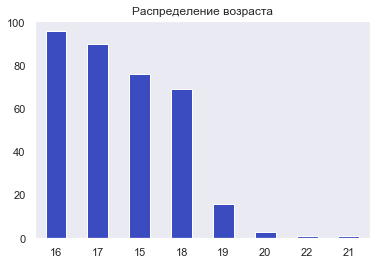

In [172]:
new_df['age'].value_counts().plot(kind = 'bar', 
                              grid = False, 
                              colormap = 'coolwarm', 
                              title = 'Распределение возраста',
                              rot=0)

**Анализ выбросов:**

In [173]:
check_outliers(new_df['age'])

,lower_bound,upper_bound
0,13.0,21.0


Наблюдение, с возрастом 22 являлось бы выбросом, но поскольку в описании данных заявлен возрастной дианазон от 15 до 22 лет - не будем его удалять.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от возраста')

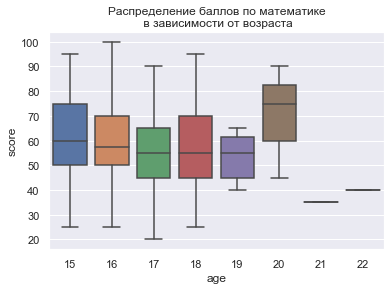

In [174]:
sns.boxplot(x = 'age', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от возраста')

Из графика видно, что с 15 до 18 лет медианная успеваемость по математике снижается, а затем растет к 19 и 20 годам.

### **Cемейные отношения**

**Анализ пропущенных значений:**

In [175]:
remove_na('famrel')

There were 24 missings that have been removed


**Анализ значений переменной:**

In [176]:
new_df.famrel = new_df.famrel.astype('str')
get_stats(new_df['famrel'])

There are 6 unique values in this variable: ['4.0' '5.0' '3.0' '-1.0' '2.0' '1.0'] 
Counts:       famrel
4.0      163
5.0       88
3.0       56
2.0       14
1.0        6
-1.0       1 
Additional info:


,Statistic,Value
0,count,328
1,unique,6
2,top,4.0
3,freq,163


В данных видна опечатка, исправим ее:

In [177]:
new_df['famrel'] = new_df['famrel'].replace(['-1.0'],'1.0')

In [178]:
get_stats(new_df['famrel'])

There are 5 unique values in this variable: ['4.0' '5.0' '3.0' '1.0' '2.0'] 
Counts:      famrel
4.0     163
5.0      88
3.0      56
2.0      14
1.0       7 
Additional info:


,Statistic,Value
0,count,328
1,unique,5
2,top,4.0
3,freq,163


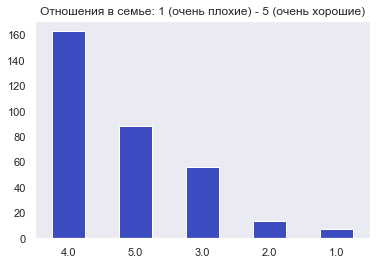

In [179]:
new_df['famrel'].value_counts().plot(kind = 'bar', 
                              grid = False, 
                              colormap = 'coolwarm', 
                              title = 'Отношения в семье: 1 (очень плохие) - 5 (очень хорошие)',
                              rot=0)

В диапазоне от 1 - очень плохие и 5 - очень хорошие, большинство учеников оценивают отношения в семье как почти очень хорошие.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от благополучия семейных отношени\n [1-плохие, 5-хорошие]')

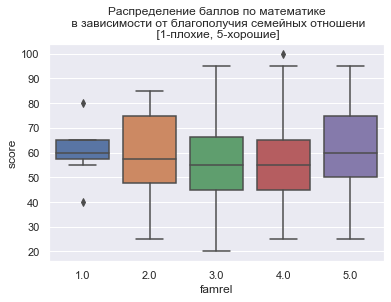

In [180]:
sns.boxplot(x = 'famrel', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от благополучия семейных отношени\n [1-плохие, 5-хорошие]')

Видно, что медианное значение балла по математике у учеников, чьи семьи имеют очень плохие или же очень хорошие отношения почти одинаковый, что довольно интересно. Хотя нужно также иметь ввиду, что в категории "очень плохие" довольно мало наблюдений, поэтому сравнивать их не совсем имеет смысл.

### **Cвободное время после школы**

**Анализ пропущенных значений:**

In [181]:
remove_na('freetime')

There were 8 missings that have been removed


**Анализ значений переменной:**

In [182]:
new_df.freetime = new_df.freetime.astype('str')
get_stats(new_df['freetime'])

There are 5 unique values in this variable: ['3.0' '2.0' '4.0' '1.0' '5.0'] 
Counts:      freetime
3.0       132
4.0       102
2.0        59
5.0        35
1.0        16 
Additional info:


,Statistic,Value
0,count,344
1,unique,5
2,top,3.0
3,freq,132


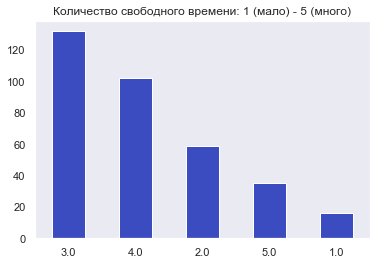

In [183]:
new_df['freetime'].value_counts().plot(kind = 'bar', 
                              grid = False, 
                              colormap = 'coolwarm', 
                              title = 'Количество свободного времени: 1 (мало) - 5 (много)',
                              rot=0)

В диапазоне от 1 - очень мало и 5 - очень много, большинство учеников оценивают количество своего свободного времени как "среднее", однако также есть достаточно людей, у кого много свободного времени.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от количества свободного времени\n [1-мало, 5-много]')

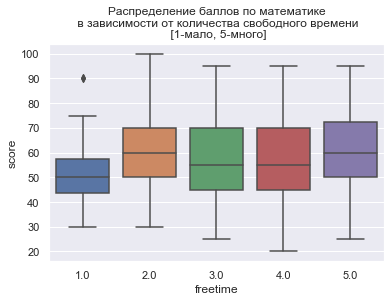

In [184]:
sns.boxplot(x = 'freetime', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от количества свободного времени\n [1-мало, 5-много]')

Сложно проследить какой-то закономерный паттерн взаимосвязи между количеством свободного времени и оценкой по математике.

### **Текущее состояние здоровья**

**Анализ пропущенных значений:**

In [185]:
remove_na('health')

There were 13 missings that have been removed


**Анализ значений переменной:**

In [186]:
new_df.health = new_df.health.astype('str')
get_stats(new_df['health'])

There are 5 unique values in this variable: ['3.0' '5.0' '1.0' '2.0' '4.0'] 
Counts:      health
5.0     124
3.0      81
4.0      53
1.0      45
2.0      36 
Additional info:


,Statistic,Value
0,count,339
1,unique,5
2,top,5.0
3,freq,124


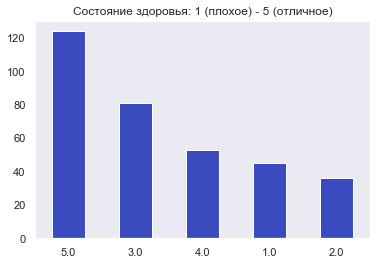

In [187]:
new_df['health'].value_counts().plot(kind = 'bar', 
                              grid = False, 
                              colormap = 'coolwarm', 
                              title = 'Состояние здоровья: 1 (плохое) - 5 (отличное)',
                              rot=0)

В диапазоне от 1 - очень плохое и 5 - очень хорошее, большинство учеников оценивают свое здоровье как "очень хорошее", и в среднем ученики склонны оценивать свое здоровье положительно.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от состояния здоровья\n [1-плохое, 5-отличное]')

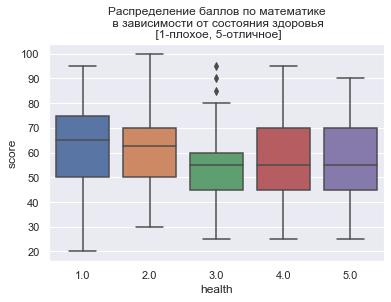

In [188]:
sns.boxplot(x = 'health', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от состояния здоровья\n [1-плохое, 5-отличное]')

Боксплоты показывают, что, как ни странно, ученики с плохим здоровьем в среднем учатся лучше.

### **Количество пропущенных занятий**

**Анализ пропущенных значений:**

In [189]:
remove_na('absences')

There were 10 missings that have been removed


**Анализ значений переменной:**

In [190]:
new_df.absences = new_df.absences.astype('int')
get_stats(new_df['absences'])

There are 36 unique values in this variable: [  6   4  10   2   0  16  14   7   8  25  12  54  18  26  20  56  24  28
   5  13  15  22   3 385  21   1  75  30  19   9  11  38  40  23  17 212] 
Counts:      absences
0          74
2          60
4          52
6          30
8          20
10         17
14         12
12         12
16          7
3           7
7           6
5           5
18          5
20          4
22          3
1           3
9           3
15          2
11          2
13          2
385         1
212         1
19          1
21          1
23          1
24          1
25          1
26          1
28          1
30          1
38          1
40          1
54          1
56          1
75          1
17          1 
Additional info:


,Statistic,Value
0,count,342.0
1,mean,8.1
2,std,24.7
3,min,0.0
4,25%,2.0
5,50%,4.0
6,75%,8.0
7,max,385.0


В среднем ученики пропускали от 2 до 8 занятий, что соответствует межкваритильному размаху, однако есть и те, кто не пропускал совсем, а также же, кто пропустил очень много. 

Посмотрим на выбросы. Верхняя граница пропусков - 17, соответственно удалим наблюдения в датасете показывают крайне нетипичное количество пропусков занятий.

In [191]:
check_outliers(new_df['absences'])

,lower_bound,upper_bound
0,-7.0,17.0


In [192]:
new_df = new_df[new_df.absences<18]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


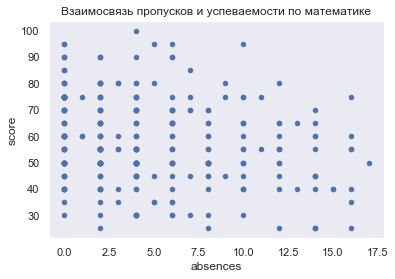

In [193]:
new_df.plot(x = 'absences', 
        y = 'score', 
        kind = 'scatter', 
        grid = False,
        title = 'Взаимосвязь пропусков и успеваемости по математике')

Никакой взаимосвязи между количеством пропусков и баллами по математике выявить не удалось.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### Итог работы с количественными переменными:

Проведя корреляционный анализ и проанализировав переменные по отдельности, в финальный датасет можно включить следующие переменные:

* Возраст
* Отношения в семье
* Количество свободного времени
* Состояние здоровья

## Анализ номинативных предикторов

### **Школа**

**Анализ пропущенных значений:**

In [194]:
remove_na('school')

There were 0 missings that have been removed


**Анализ значений переменной:**

In [195]:
get_stats(new_df['school'])

There are 2 unique values in this variable: ['GP' 'MS'] 
Counts:     school
GP     311
MS      41 
Additional info:


,Statistic,Value
0,count,352
1,unique,2
2,top,GP
3,freq,311


Как видно из краткого анализа переменной, а данных представлено только 2 школы, причем большинство учеников (более 85 %) принадлежат школе GP.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от школы')

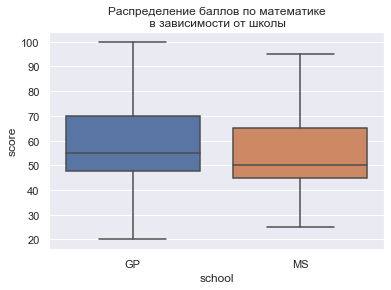

In [196]:
sns.boxplot(x = 'school', y = 'score', data = new_df).set_title('Распределение баллов по математике\n в зависимости от школы')

По графику видно, что медианный балл по математике в первой школе (GP) выше, чем во второй (MS). Хоть разница и не большая, эта переменная может быть потенциально полезной в предсказании.

### **Пол ученика**

**Анализ пропущенных значений:**

In [197]:
remove_na('sex')

There were 0 missings that have been removed


**Анализ значений переменной:**

In [198]:
get_stats(new_df['sex'])

There are 2 unique values in this variable: ['F' 'M'] 
Counts:    sex
F  182
M  170 
Additional info:


,Statistic,Value
0,count,352
1,unique,2
2,top,F
3,freq,182


Как можно заметить, как мальчики, так и девочки представлены в данных почти в равном количестве, с небольшим перевесом в сторону мужского пола.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от пола')

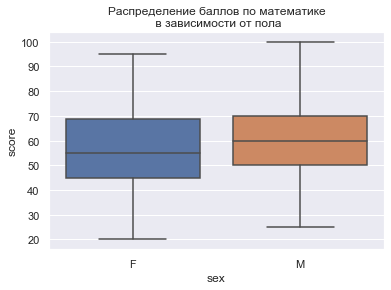

In [199]:
sns.boxplot(x = 'sex', y = 'score', data = new_df).set_title('Распределение баллов по математике\n в зависимости от пола')

Из графика видно, что мальчики, в среднем, получают более высокие баллы по математике. Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Тип местности проживания**

**Анализ пропущенных значений:**

In [200]:
remove_na('address')

There were 14 missings that have been removed


**Анализ значений переменной:**

In [201]:
get_stats(new_df['address'])

There are 2 unique values in this variable: ['U' 'R'] 
Counts:    address
U      265
R       73 
Additional info:


,Statistic,Value
0,count,338
1,unique,2
2,top,U
3,freq,265


Большинство (около 80 %) учащихся проживают в городской местности (*Urban*), в то время как около 20 % - в сельской (*Rural*).

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от места проживания')

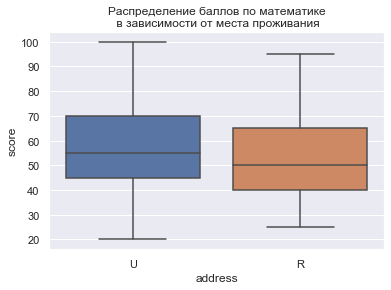

In [202]:
sns.boxplot(x = 'address', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от места проживания')

Из графика видно, что ученики из городской местности учатся, в среднем, чуть лучше, чем ученики из сельской местности. Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Размер семьи**

**Анализ пропущенных значений:**

In [203]:
remove_na('famsize')

There were 24 missings that have been removed


**Анализ значений переменной:**

In [204]:
get_stats(new_df['famsize'])

There are 2 unique values in this variable: ['GT3' 'LE3'] 
Counts:      famsize
GT3      228
LE3      100 
Additional info:


,Statistic,Value
0,count,328
1,unique,2
2,top,GT3
3,freq,228


Большинство учеников (около 70 %) живут в семьях, где количество ее членов превышает 3 человека, остальные 30 % - в семьях, не превышаюших эту отметку.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от размера семьи')

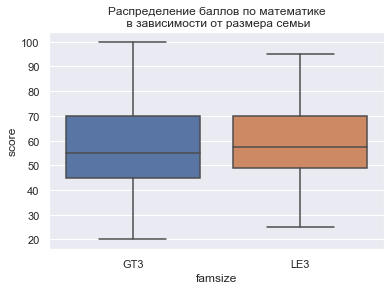

In [205]:
sns.boxplot(x = 'famsize', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от размера семьи')

Из графика видно, что существенную разницу между учениками из семей с количеством членов больше и меньше трех отследить сложно. Медианные значения оценки по математике практически идентичны в том и другом случае.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Статус совместного сожительства родителей**

**Анализ пропущенных значений:**

In [206]:
remove_na('Pstatus')

There were 41 missings that have been removed


**Анализ значений переменной:**

In [207]:
get_stats(new_df['Pstatus'])

There are 2 unique values in this variable: ['A' 'T'] 
Counts:    Pstatus
T      277
A       34 
Additional info:


,Statistic,Value
0,count,311
1,unique,2
2,top,T
3,freq,277


Большинство родителей учеников живут вместе (90%), однако некоторая часть (10%) состоят в разводе\живут отдельно друг от друга.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от статуса совместного проживания родителей')

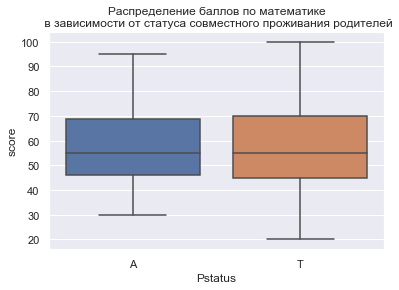

In [208]:
sns.boxplot(x = 'Pstatus', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от статуса совместного проживания родителей')

Из графика видно, что ученики, чьи родители не живут вместе имеют меньший разброс значений в оценках, чем те, у кого родители живут вместе. Однако медианной значение оценок практически индентично. Таким образов, статус совместного проживани родителей не помогает объяснить оценку по математике.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Oбразование матери**

**Анализ пропущенных значений:**

In [209]:
remove_na('Medu')

There were 2 missings that have been removed


**Анализ значений переменной:**

In [210]:
new_df.Medu = new_df.Medu.astype('str')
get_stats(new_df['Medu'])

There are 5 unique values in this variable: ['4.0' '1.0' '3.0' '2.0' '0.0'] 
Counts:      Medu
4.0   125
2.0    88
3.0    87
1.0    47
0.0     3 
Additional info:


,Statistic,Value
0,count,350
1,unique,5
2,top,4.0
3,freq,125


Более 35% матерей имеют высшее образование, ещё по 25% - имеют среднее специальное или закончили 11 классов школы/закончили 5-9 классов. Около 13% матерей закончили только 4 класса, и лишь у 3 матерей нет образования совсем.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от образования матери')

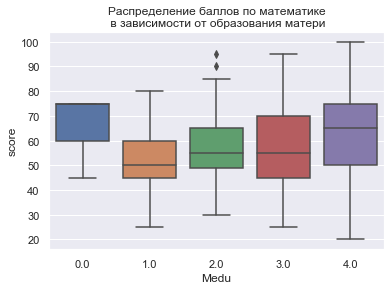

In [211]:
sns.boxplot(x = 'Medu', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от образования матери')

Из графика видно, что ученики, чьи матери имеют высшее или хотя бы среднее специальное образование учатся существенно лучше. Ученики, матери которых не имеют достаточного образования (несколько классов школы) практически не фигурируют среди учеников, получающих наивысшие оценки по математике.

Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Oбразование отца**

**Анализ пропущенных значений:**

In [212]:
remove_na('Fedu')

There were 21 missings that have been removed


**Анализ значений переменной:**

In [213]:
new_df.Fedu = new_df.Fedu.astype('str')
get_stats(new_df['Fedu'])

There are 6 unique values in this variable: ['4.0' '1.0' '2.0' '3.0' '40.0' '0.0'] 
Counts:       Fedu
2.0     94
3.0     89
4.0     80
1.0     65
0.0      2
40.0     1 
Additional info:


,Statistic,Value
0,count,331
1,unique,6
2,top,2.0
3,freq,94


Видна опечатка в данных, исправим ее:

In [214]:
new_df['Fedu'] = new_df['Fedu'].replace(['40.0'], '4.0')

In [215]:
get_stats(new_df['Fedu'])

There are 5 unique values in this variable: ['4.0' '1.0' '2.0' '3.0' '0.0'] 
Counts:      Fedu
2.0    94
3.0    89
4.0    81
1.0    65
0.0     2 
Additional info:


,Statistic,Value
0,count,331
1,unique,5
2,top,2.0
3,freq,94


Около 25% отцов имеют высшее образование, около 27% - имеют среднее специальное или закончили 11 классов школы, 28% - закончили 5-9 классов. Около 20% отцов закончили только 4 класса, и лишь у 2 отцов нет образования совсем.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от образования отца')

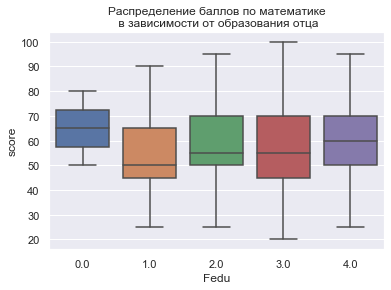

In [216]:
sns.boxplot(x = 'Fedu', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от образования отца')

Из графика видно, что образование отца влияет на успеваемость по математике похожим образом, что и образование матери, однако наблюдается более слабая зависимость. Для дальнейшего анализа имеет смысл объединить эти переменных, поскольку для более получения более информативной метрики.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Pабота матери**

**Анализ пропущенных значений:**

In [217]:
remove_na('Mjob')

There were 17 missings that have been removed


**Анализ значений переменной:**

In [218]:
get_stats(new_df['Mjob'])

There are 5 unique values in this variable: ['at_home' 'health' 'other' 'services' 'teacher'] 
Counts:           Mjob
other      115
services    90
teacher     51
at_home     49
health      30 
Additional info:


,Statistic,Value
0,count,335
1,unique,5
2,top,other
3,freq,115


Большинство матерей работают в сфере обслживания или других секторах рынка.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от работы матери')

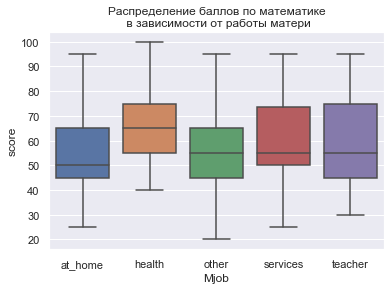

In [219]:
sns.boxplot(x = 'Mjob', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от работы матери')

Из графика видно, медианное значение оценки по математике наибольшее у детей, мамы которых работают в сфере здравоохранения, в то время как наименьшее - у детей, мамы которых работают из дома или являются домохозяйками. Вариация в медианных значениях и межквартильных размахах довольно заметна, поэтом переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Pабота отца**

**Анализ пропущенных значений:**

In [220]:
remove_na('Fjob')

There were 32 missings that have been removed


**Анализ значений переменной:**

In [221]:
get_stats(new_df['Fjob'])

There are 5 unique values in this variable: ['teacher' 'other' 'health' 'services' 'at_home'] 
Counts:           Fjob
other      176
services    89
teacher     26
health      15
at_home     14 
Additional info:


,Statistic,Value
0,count,320
1,unique,5
2,top,other
3,freq,176


Большинство отцов также работают в сфере обслживания или других секторах рынка.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от работы отца')

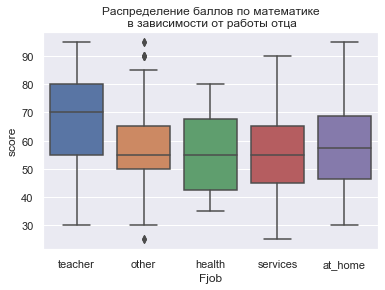

In [222]:
sns.boxplot(x = 'Fjob', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от работы отца')

Из графика видно, что паттерн взаимосвязи между переменными отличен от ситуации с работой матери: ученики, чьи папы заняты в сфере педагогики, получают наивысшие баллы по математике и в среднем учаться гораздо лучше, по сравнению с учениками, чьи отцы заняты в других сферах.
Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Причина выбора школы**

**Анализ пропущенных значений:**

In [223]:
remove_na('reason')

There were 15 missings that have been removed


**Анализ значений переменной:**

In [224]:
get_stats(new_df['reason'])

There are 4 unique values in this variable: ['course' 'other' 'home' 'reputation'] 
Counts:             reason
course         119
reputation      96
home            89
other           33 
Additional info:


,Statistic,Value
0,count,337
1,unique,4
2,top,course
3,freq,119


Большинство родителей выбирали школы для своих детей основываясь на представленных ученых программах, а также на репутации школы.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от причины выбора школы')

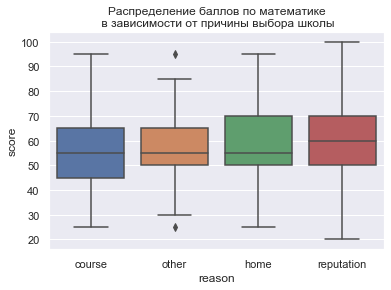

In [225]:
sns.boxplot(x = 'reason', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от причины выбора школы')

Из графика видно, что медианная оценка по математике учеников, чьи родители выбирали школу исходя из ее репутации, выше, чем у учеников, родители которых принимали решение о поступлении в школу по другим причинам. 

Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Опекун**

**Анализ пропущенных значений:**

In [226]:
remove_na('guardian')

There were 29 missings that have been removed


**Анализ значений переменной:**

In [227]:
get_stats(new_df['guardian'])

There are 3 unique values in this variable: ['mother' 'father' 'other'] 
Counts:         guardian
mother       225
father        78
other         20 
Additional info:


,Statistic,Value
0,count,323
1,unique,3
2,top,mother
3,freq,225


Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от типа опекунства')

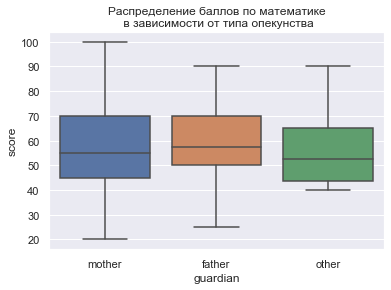

In [228]:
sns.boxplot(x = 'guardian', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от типа опекунства')

Довольно сложно оценить какаие-то отличительные особенности среди распределений оценок в зависимости от вида опекунства.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Время в пути до школы**

**Анализ пропущенных значений:**

In [229]:
remove_na('traveltime')

There were 23 missings that have been removed


**Анализ значений переменной:**

In [230]:
new_df.traveltime = new_df.traveltime.astype('str')
get_stats(new_df['traveltime'])

There are 4 unique values in this variable: ['2.0' '1.0' '3.0' '4.0'] 
Counts:      traveltime
1.0         219
2.0          86
3.0          17
4.0           7 
Additional info:


,Statistic,Value
0,count,329
1,unique,4
2,top,1.0
3,freq,219


Большинство учеников тратят <15 мин., чтобы добраться до школы. Некоторые тратят 15-30 мин., ещё меньшее количество - 30-60 мин., и лишь 7 человек тратят >60 мин.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от траты времени на дорогу до школы\n [1 - мало, 4 - много]')

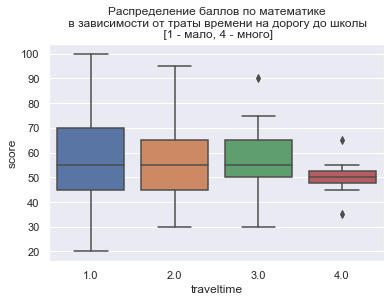

In [231]:
sns.boxplot(x = 'traveltime', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от траты времени на дорогу до школы\n [1 - мало, 4 - много]')

Медианное значение оценки практически идентично в зависимости от разного количества времени, затрачиваемого на дорогу до школы.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Время на учёбу помимо школы в неделю**

**Анализ пропущенных значений:**

In [232]:
remove_na('studytime')

There were 7 missings that have been removed


**Анализ значений переменной:**

In [233]:
new_df.studytime = new_df.studytime.astype('str')
get_stats(new_df['studytime'])

There are 4 unique values in this variable: ['2.0' '3.0' '1.0' '4.0'] 
Counts:      studytime
2.0        173
1.0         90
3.0         58
4.0         24 
Additional info:


,Statistic,Value
0,count,345
1,unique,4
2,top,2.0
3,freq,173


Около четверти учеников тратят <2 часов для занятий учебой помимо школы в неделю, около 50% - 2-5 часов, ещё 17% - 5-10 часов, и около 7% >10 часов в неделю.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от времени на учебы вне школы\n [1 - мало, 4 - много]')

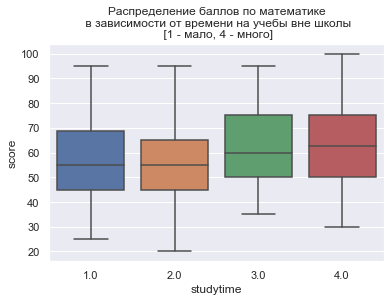

In [234]:
sns.boxplot(x = 'studytime', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от времени на учебы вне школы\n [1 - мало, 4 - много]')

Из графика очевидно, что чем больше ученики тратят время на подготовку домашнего задания и самостоятельное обучение, тем выше медианное значение их балла по математике.

Таким образом, переменную стоит оставить для добавления в финальную модель в качестве предиктора.

### **Дополнительная образовательная поддержка**

**Анализ пропущенных значений:**

In [235]:
remove_na('schoolsup')

There were 9 missings that have been removed


**Анализ значений переменной:**

In [236]:
get_stats(new_df['schoolsup'])

There are 2 unique values in this variable: ['yes' 'no'] 
Counts:      schoolsup
no         295
yes         48 
Additional info:


,Statistic,Value
0,count,343
1,unique,2
2,top,no
3,freq,295


Дополнительную образовательную поддержку от школу получают около 1/7 учеников школы.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от наличия академической помощи в школе')

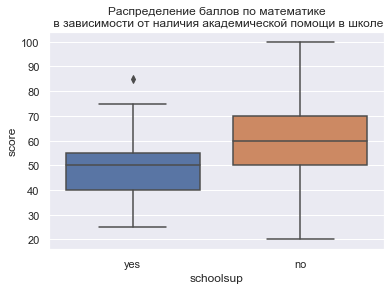

In [237]:
sns.boxplot(x = 'schoolsup', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от наличия академической помощи в школе')

Из графика видно, что школьную поддержку получают, вероятнее всего, отстающие ученики или ученики с особенностями развития, поскольку те, кто поддержки НЕ получает, учатся, в среднем, лучше. 

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Семейная образовательная поддержка**

**Анализ пропущенных значений:**

In [238]:
remove_na('famsup')

There were 36 missings that have been removed


**Анализ значений переменной:**

In [239]:
get_stats(new_df['famsup'])

There are 2 unique values in this variable: ['no' 'yes'] 
Counts:      famsup
yes     196
no      120 
Additional info:


,Statistic,Value
0,count,316
1,unique,2
2,top,yes
3,freq,196


Дополнительную образовательную поддержку в семье получают около 2/3 учеников школы.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от академической помощи дома')

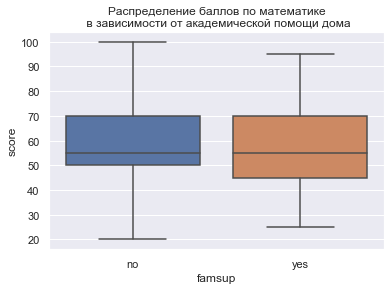

In [240]:
sns.boxplot(x = 'famsup', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от академической помощи дома')

Из графика видно, что поддержка семьи в образовательном плане не сильно сказывается на академических успехах по математике, по сравнению с учениками, кто такой поддержки не получает. Медианные показатели практически равны в обоих случаях.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Дополнительные платные занятия по математике**

**Анализ пропущенных значений:**

In [241]:
remove_na('paid')

There were 36 missings that have been removed


**Анализ значений переменной:**

In [242]:
get_stats(new_df['paid'])

There are 2 unique values in this variable: ['no' 'yes'] 
Counts:      paid
no    170
yes   146 
Additional info:


,Statistic,Value
0,count,316
1,unique,2
2,top,no
3,freq,170


Дополнительными платными занятиями по математике занимаются около 45% учеников школы.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от наличия репетитора')

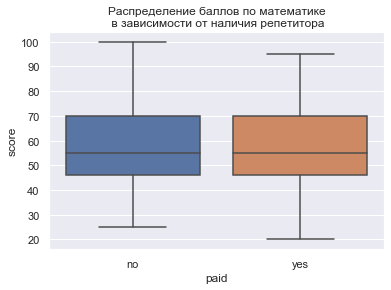

In [243]:
sns.boxplot(x = 'paid', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от наличия репетитора')

Как бы удивительно ни было, ученики, которые посещяют платные занятия с репетитором по математике в среднем получают такие же оценка как и те, кто репетитора не посещает. Медианные значения и межквартильный размах почти идентичны для обоих случаев.

Таким образом, переменную скорее не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Дополнительные внеучебные занятия**

**Анализ пропущенных значений:**

In [244]:
remove_na('activities')

There were 12 missings that have been removed


**Анализ значений переменной:**

In [245]:
get_stats(new_df['activities'])

There are 2 unique values in this variable: ['no' 'yes'] 
Counts:      activities
yes         172
no          168 
Additional info:


,Statistic,Value
0,count,340
1,unique,2
2,top,yes
3,freq,172


Дополнительными внеучебными занятиями занимаются около половины учеников школы.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от посещения внешкольных занятий')

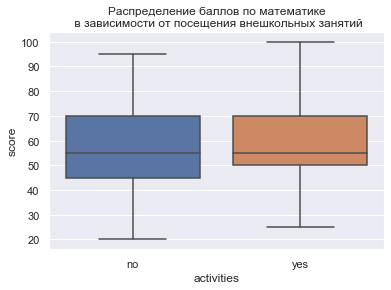

In [246]:
sns.boxplot(x = 'activities', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от посещения внешкольных занятий')

Из графика видно, что ученики, посещающие кружки или хобби по интересам вне учебных занятий, в среднем учаться немного лучше, чем те, кто занятий не посещает.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Посещал ли ученик детский сад**

**Анализ пропущенных значений:**

In [247]:
remove_na('nursery')

There were 12 missings that have been removed


**Анализ значений переменной:**

In [248]:
get_stats(new_df['nursery'])

There are 2 unique values in this variable: ['yes' 'no'] 
Counts:      nursery
yes      272
no        68 
Additional info:


,Statistic,Value
0,count,340
1,unique,2
2,top,yes
3,freq,272


Детский сад посещали около 80% учеников школы.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от факта посещения детского сада')

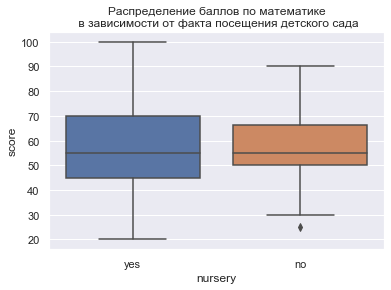

In [249]:
sns.boxplot(x = 'nursery', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от факта посещения детского сада')

Из графика видно, что медианные значения почти равны, однако те, кто посещал детский сад, также в среднем чаще получают более высокие и более низкие оценки.

Таким образом, переменную не стоит оставлять для добавления в финальную модель в качестве предиктора.

### **Хочет ли ученик получить высшее образование**

**Анализ пропущенных значений:**

In [250]:
remove_na('higher')

There were 19 missings that have been removed


**Анализ значений переменной:**

In [251]:
get_stats(new_df['higher'])

There are 2 unique values in this variable: ['yes' 'no'] 
Counts:      higher
yes     320
no       13 
Additional info:


,Statistic,Value
0,count,333
1,unique,2
2,top,yes
3,freq,320


Почти все ученики хотят получать высшее образование в будущем.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от стремения получить высшее образование')

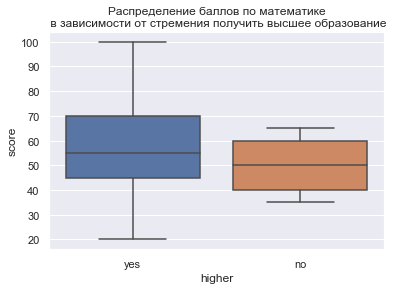

In [252]:
sns.boxplot(x = 'higher', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от стремения получить высшее образование')

Из графика видно, что не желающие получать высшее образование ученики не набирают наивысших баллов по математике. Вероятнее всего из-за отсутствия достаточной мотивации. В остальном, последние также показывают худшие медианные результаты.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Наличие интернета дома**

**Анализ пропущенных значений:**

In [253]:
remove_na('internet')

There were 29 missings that have been removed


**Анализ значений переменной:**

In [254]:
get_stats(new_df['internet'])

There are 2 unique values in this variable: ['yes' 'no'] 
Counts:      internet
yes       274
no         49 
Additional info:


,Statistic,Value
0,count,323
1,unique,2
2,top,yes
3,freq,274


Около 15% учеников не имеют доступ в Интернет из дома.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от доступности интернета')

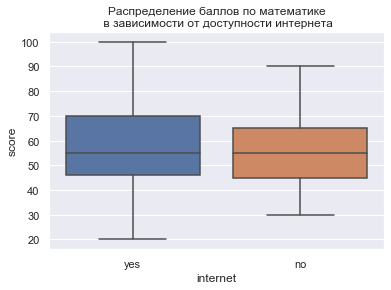

In [255]:
sns.boxplot(x = 'internet', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от доступности интернета')

Из графика видно, что доступ в интернет из дома в среднем положительно влияет на успеваемость по математике, поскольку это позволяет учениками получать наивысшие оценки. Однако медианные значения почти равны.

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Состоит ли ученик в романтических отношениях**

**Анализ пропущенных значений:**

In [256]:
remove_na('romantic')

There were 29 missings that have been removed


**Анализ значений переменной:**

In [257]:
get_stats(new_df['romantic'])

There are 2 unique values in this variable: ['no' 'yes'] 
Counts:      romantic
no        219
yes       104 
Additional info:


,Statistic,Value
0,count,323
1,unique,2
2,top,no
3,freq,219


Около 1/3 учеников состоят в романтических отношениях.

Text(0.5, 1.0, 'Распределение баллов по математике\n в зависимости от наличия романтических отношений')

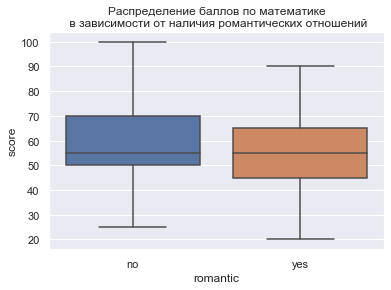

In [258]:
sns.boxplot(x = 'romantic', y = 'score', data = new_df).\
set_title('Распределение баллов по математике\n в зависимости от наличия романтических отношений')

Из графика видно, что ученики, не состоящие в романтических отношениях в среднем намного чаще получают более высокие оценки по математике, по сравнению с тем, кто состоит в отношениях. 

Таким образом, переменную можно оставить для добавления в финальную модель в качестве предиктора.

### **Вывод**

В ходе эксплораторного анализа были выявлены следующие предикторы, которые при первичном обследовании оказались взаимосвязаны с зависимой переменной "балл по математике" и потенциально могут быть включены в финальную предсказательную модель:

* Пол ученика
* Тип жилой местности
* Образование матери
* Образование отца
* Работа матери
* Работа отца
* Время, затрачиваемое на учебу вне школы
* Посещение внеучебных занятий 
* Желание получить высшее образование
* Доступ в интернет
* Наличае романтических отношений
* Благополучность отношений в семье
* Количество свободного времени
* Причина выбора школы родителями
* Возраст
* Состояние здоровья